<a href="https://colab.research.google.com/github/kimhwijin/TensorflowWithKeras/blob/master/Autoencoder/Stack_CNN_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
import numpy as np

Stacked CNN Autoencoder
<br>Autoencoder 여러개를 덧붙여 이어서 stacked autoencoder 를 만든다.
<br>이 autoencoder는 전체로서 훈련하거나,
<br>각각의 autoencoder를 훈련시킨후, 전체 autoencoder를 미세조정할 수 있다.

In [2]:
np.random.seed(11)
tf.random.set_seed(11)

batch_size = 128
max_epochs = 50
filters = [32, 32, 16]

In [3]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise = 0.5
x_train_noisy = x_train + noise * np.random.normal(loc=0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise * np.random.normal(loc=0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

x_train_noisy = x_train_noisy.astype('float32')
x_test_noisy = x_test_noisy.astype('float32')

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
class Encoder(K.layers.Layer):
    def __init__(self, filters):
        super(Encoder, self).__init__()
        self.conv1 = K.layers.Conv2D(filters=filters[0], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv2 = K.layers.Conv2D(filters=filters[1], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv3 = K.layers.Conv2D(filters=filters[2], kernel_size=3, strides=1, activation='relu', padding='same')
        self.pool = K.layers.MaxPooling2D((2, 2), padding='same')
    
    def call(self, input_features):
        #print(input_features.shape)
        x = self.conv1(input_features)
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = self.conv2(x)
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = self.conv3(x)
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        return x

class Decoder(K.layers.Layer):
    def __init__(self, filters):
        super(Decoder, self).__init__()
        self.conv1 = K.layers.Conv2D(filters=filters[2], kernel_size=3, strides=1, padding='same', activation='relu')
        self.conv2 = K.layers.Conv2D(filters=filters[1], kernel_size=3, strides=1, padding='same', activation='relu')
        self.conv3 = K.layers.Conv2D(filters=filters[0], kernel_size=3, strides=1, padding='valid', activation='relu')
        self.conv4 = K.layers.Conv2D(1, 3, 1, padding='same', activation='sigmoid')
        self.upsample = K.layers.UpSampling2D((2, 2))
    
    def call(self, encoded):
        #print(encoded.shape)
        x = self.conv1(encoded)
        #print(x.shape)
        x = self.upsample(x)
        #print(x.shape)
        x = self.conv2(x)
        #print(x.shape)
        x = self.upsample(x)
        #print(x.shape)
        x = self.conv3(x)
        #print(x.shape)
        x = self.upsample(x)
        #print(x.shape)
        x = self.conv4(x)
        #print(x.shape)
        return x

class Autoencoder(K.Model):
    def __init__(self, filters):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(filters)
        self.decoder = Decoder(filters)
    
    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed

In [5]:
model = Autoencoder(filters)
model.compile(loss='binary_crossentropy', optimizer='adam')
loss = model.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), batch_size=batch_size, epochs=max_epochs)

Epoch 1/50
469/469 [==============================] - 36s 8ms/step - loss: 0.2051 - val_loss: 0.1504
Epoch 2/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1418 - val_loss: 0.1327
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1289 - val_loss: 0.1239
Epoch 4/50
469/469 [==============================] - 4s 7ms/step - loss: 0.1224 - val_loss: 0.1194
Epoch 5/50
469/469 [==============================] - 4s 8ms/step - loss: 0.1180 - val_loss: 0.1150
Epoch 6/50
469/469 [==============================] - 4s 8ms/step - loss: 0.1148 - val_loss: 0.1124
Epoch 7/50
469/469 [==============================] - 4s 8ms/step - loss: 0.1125 - val_loss: 0.1103
Epoch 8/50
469/469 [==============================] - 4s 8ms/step - loss: 0.1110 - val_loss: 0.1092
Epoch 9/50
469/469 [==============================] - 4s 8ms/step - loss: 0.1094 - val_loss: 0.1081
Epoch 10/50
469/469 [==============================] - 4s 8ms/step - loss: 0.1082 - val_loss: 0.107

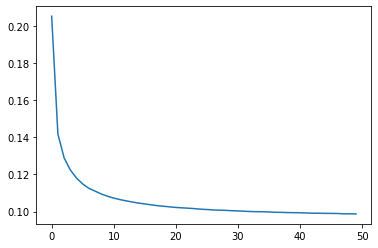

In [6]:
plt.plot(range(max_epochs), loss.history['loss'])
plt.show()


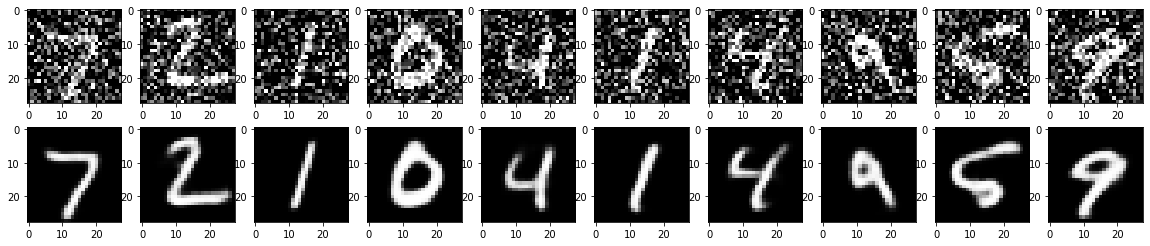

In [7]:
number = 10
plt.figure(figsize=(20, 4))
for index in range(number):
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28, 28), cmap='gray')

    ax = plt.subplot(2, number, index + number + 1)
    plt.imshow(tf.reshape(model(x_test_noisy)[index], (28, 28)) , cmap='gray')

plt.show()